# Personal Information
Name: Thomas Koene

StudentID: 12855723

Email: [**12855723@student.uva.nl**](12855723@student.uva.nl)

Submitted on: **22.03.2024**

# Data Context

I'm using one big dataset, which is compressed about 13 GB big, containing labelled images of damages on the road surface. The dataset can be found at https://doi.org/10.48550/arXiv.2209.08538, where documentation can also be found giving some general information in the structure and meaning of the data. If this dataset turns out not to work, I can always resort to the 2018 version of this dataset, which has already been used a lot to train similar models. 

The idea is that I will train different models, trained on images from individual countries, to identify road damages. The goal is to find differences in performance of these models, where I'll research if these performance differences can be linked to for example investment in road infrastructure, or differences in weather and lighting conditions in these countries.  

### Loading packages

In [1]:
import os
import numpy as np
import pandas as pd
from zipfile import ZipFile

from xml.etree import cElementTree as ET
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
from matplotlib import patches, text, patheffects

# !pip install StringIO
from io import StringIO

from IPython.display import Image

# Exploratory Data Analisys

### What is the structure of the dataset?

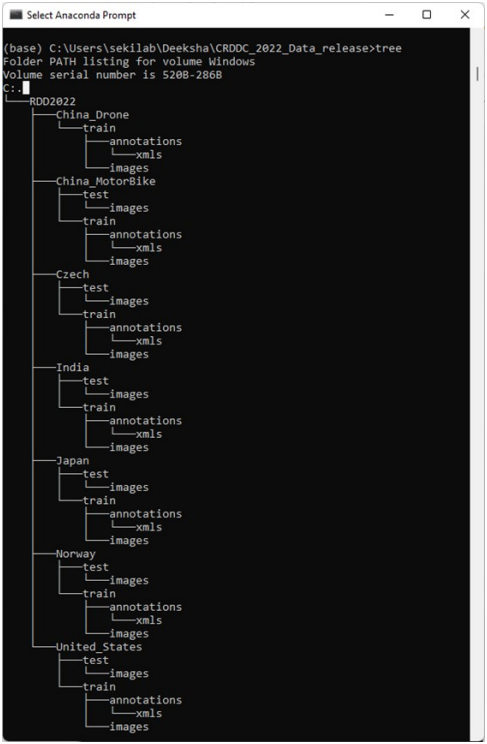

In [2]:
Image(filename='dataset_structure.png')

Observation: What can be see here is that the folder consists of folders of individual countries. For each country, there is a test and a train folder. The test folders only contain images, and the train folder constist of a folder with annotations and a folder containing the images. All clear!

### How many countries are included in the dataset?

In [3]:
# list all the folders (=countries) in the zipped dataset
with ZipFile('RDD2022.zip', 'r') as zip: 
    folders = zip.namelist()
countries = [folder.strip('RDD2022_all_countries/').strip('.zip') for folder in folders]

# print all the different folders, and thus countries in the dataset
print("Countries included in dataset: \n")
for i, country in enumerate(countries):
    print(i+1, country)

Countries included in dataset: 

1 China_Drone
2 China_MotorBike
3 Czech
4 India
5 Japan
6 Norway
7 United_States


### How many images per country?

In [4]:
# number of images per country
number_of_images = []

with ZipFile('RDD2022.zip', 'r') as zip: 
    # get all the contents of the zip file 
    files = zip.namelist()

    # for each country/country, count the number of .jpg files
    for file in files:     
        country = zip.extract(file)
        with ZipFile(country, 'r') as zip2: 
            number_of_images.append(len([i for i in list(zip2.filelist) if '.jpg' in str(i)]))

print("Total number of images in dataset: ", sum(number_of_images), "\n")

Total number of images in dataset:  47420 



In [5]:
print("Number of images per country: \n")
for i in range(len(countries)):
    print(i, countries[i], ': \t', number_of_images[i])

Number of images per country: 

0 China_Drone : 	 2401
1 China_MotorBike : 	 2477
2 Czech : 	 3538
3 India : 	 9665
4 Japan : 	 13133
5 Norway : 	 10201
6 United_States : 	 6005


### Visualising number of images per country

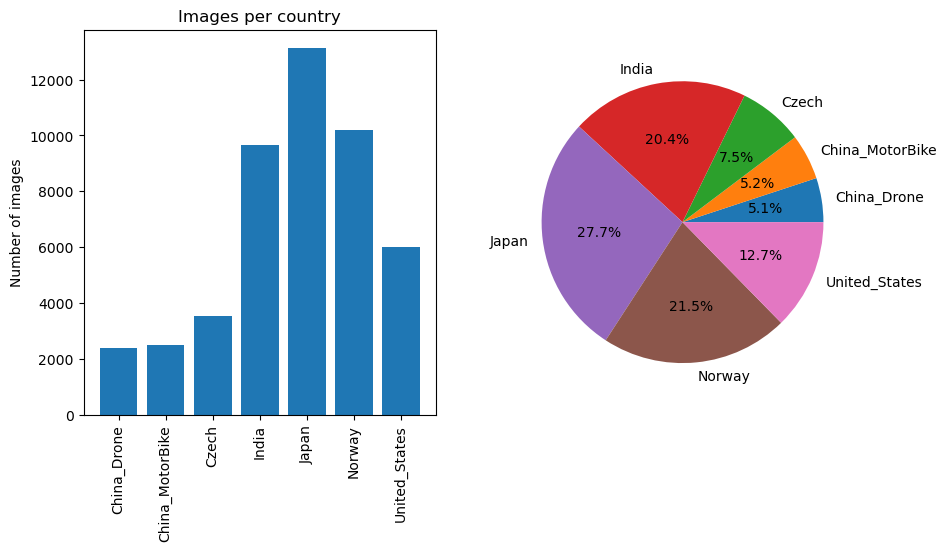

In [6]:
# create barchart and piechart of number of images per country
plt.figure(figsize=(10,5))

plt.subplot(121)
y_pos = range(len(countries))
plt.bar(y_pos, number_of_images)
plt.xticks(y_pos, countries, rotation=90)
plt.ylabel('Number of images')
plt.title('Images per country')

plt.subplot(122)
plt.pie(number_of_images, labels=countries, autopct='%0.1f%%')
plt.show()

Observation: As can be seen in the figures above, most images are captured in Japan, followed by Norway, India, the USA, Czech Republic, China_MotorBike and China_Drone

### Which part of the dataset is annotated (and thus is training data)?

In [7]:
# annotated pictures per country
annotated_number_of_images = []

with ZipFile('RDD2022.zip', 'r') as zip: 
    # get all the contents of the zip file 
    files = zip.namelist()

    # for each country/country, count the number of .jpg files that are in the train folder
    for file in files:     
        country = zip.extract(file)
        with ZipFile(country, 'r') as zip2: 
            annotated_number_of_images.append(len([i for i in list(zip2.filelist) if ('.jpg' in str(i)) & ('train' in str(i))]))


print("Total number of annotated images in dataset: ", sum(annotated_number_of_images))
print("Percentage annotated images of total number of images: ", 
      round(sum(annotated_number_of_images) / sum(number_of_images) * 100, 2))

Total number of annotated images in dataset:  38385
Percentage annotated images of total number of images:  80.95


In [8]:
print("Number of images per country: \n")
for i in range(len(countries)):
    print(i, countries[i], ': \t', annotated_number_of_images[i])

Number of images per country: 

0 China_Drone : 	 2401
1 China_MotorBike : 	 1977
2 Czech : 	 2829
3 India : 	 7706
4 Japan : 	 10506
5 Norway : 	 8161
6 United_States : 	 4805


### Visualising number of annotated images per country

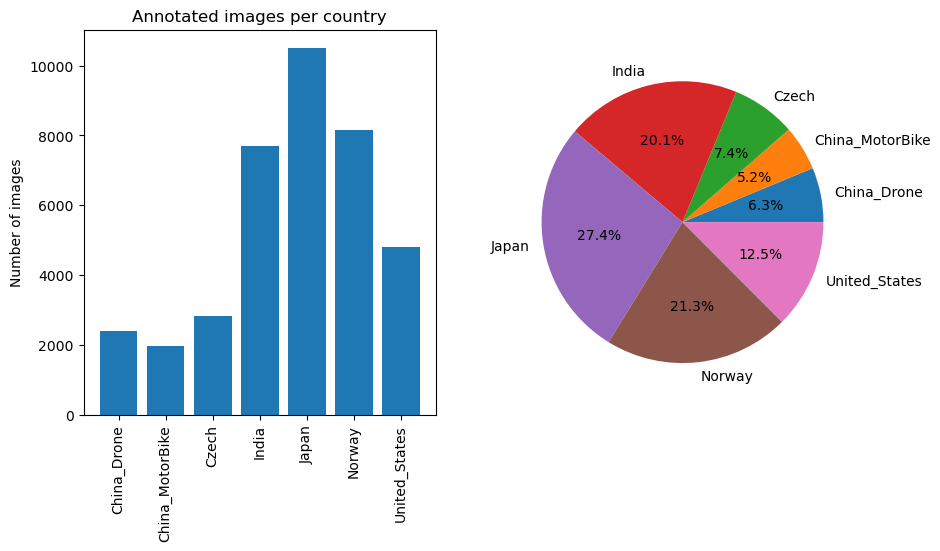

In [9]:
# create barchart and piechart of number of annotated images per country
plt.figure(figsize=(10,5))

plt.subplot(121)
y_pos = range(len(countries))
plt.bar(y_pos, annotated_number_of_images)
plt.xticks(y_pos, countries, rotation=90)
plt.ylabel('Number of images')
plt.title('Annotated images per country')

plt.subplot(122)
plt.pie(annotated_number_of_images, labels=countries, autopct='%0.1f%%')

plt.show()

Observation: The order of size of country's dataset is still the same. However, some sizes have decreased more than others compared to the all images (previous plot). Let's dive into that a bit deeper. 

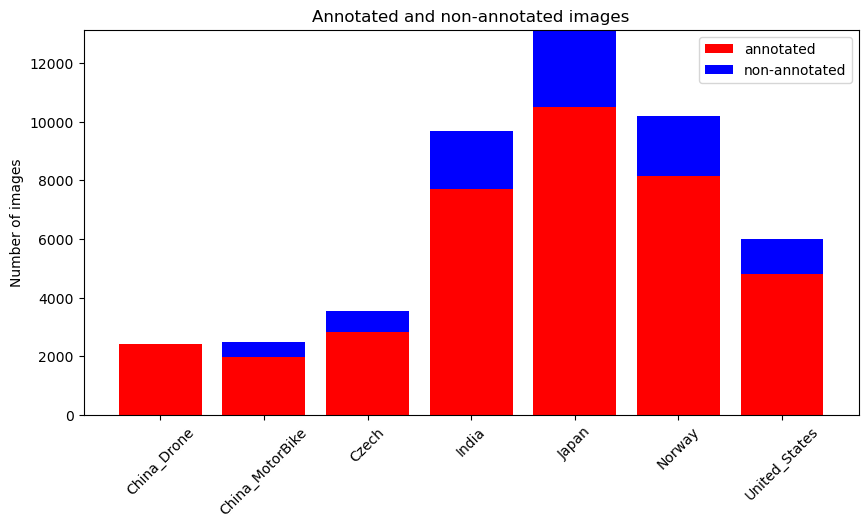

In [10]:
# create barchart of annotated and non-annotated images per country
non_annotated = np.array(annotated_number_of_images) - np.array(number_of_images)

plt.figure(figsize=(10,5))
plt.bar(countries, number_of_images, color='r', )
plt.bar(countries, non_annotated, bottom=number_of_images, color='b')
plt.xticks(rotation=45)
plt.ylabel('Number of images')
plt.title(label='Annotated and non-annotated images')

plt.legend(['annotated', 'non-annotated'])
plt.show()

In [11]:
# calculate percentage of annotated images of total number of images
print('Percentage annotated images of total number of images per country: \n')
for i in range(len(countries)):
    print(countries[i], ': ', round(annotated_number_of_images[i] / number_of_images[i] * 100, 2))

Percentage annotated images of total number of images per country: 

China_Drone :  100.0
China_MotorBike :  79.81
Czech :  79.96
India :  79.73
Japan :  80.0
Norway :  80.0
United_States :  80.02


Observation: It is interesting to see that all countries/folders contain about the same percentage of training data (+- 80%), except for 'China_Drone'. Appearently, this folder consists for 100% of training data and thus only contains labelled images. 

## Cracks

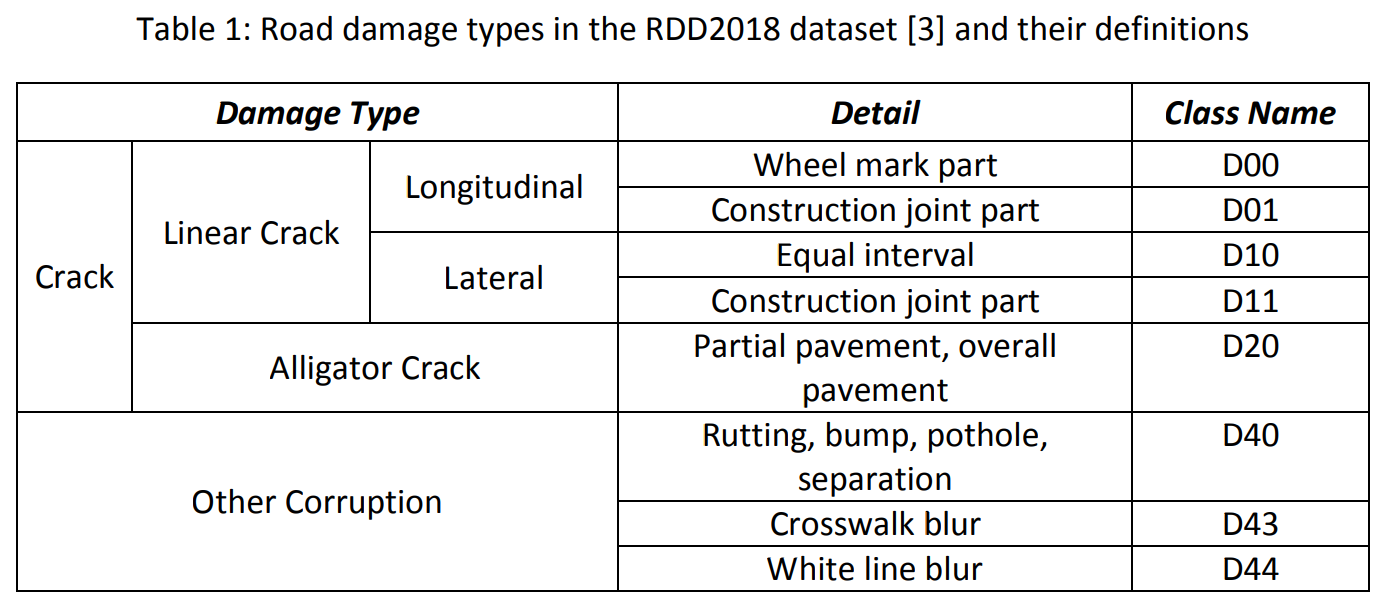

In [12]:
Image(filename='road_damage_types.png')

Observation: In the documentation of the dataset, I've found a table indicating the cracks occuring in the dataset and the meaning of the class names in the dataset. Source: https://doi.org/10.48550/arXiv.2209.08538

### Gathering the data

In [13]:
# create a dict with for every country the frequencies of crack occurrences
cracks_per_country = dict()

with ZipFile('RDD2022.zip', 'r') as zip: 
    files = zip.namelist()
    
    # go over all countries
    for file in files:
        country = zip.extract(file)
        with ZipFile(country, 'r') as zip2: 
            country = str(file).strip('RDD2022_all_countries/').strip('.zip')
            cracks = []
            
            # go over all files in folder
            for file in zip2.namelist():
                if '.xml' in file:
                    xmlstr = zip2.read(file)
                    root = ET.fromstring(xmlstr)
                    for page in list(root):
                        
                        # find all cracks and add to list
                        for name in page.findall('name'):
                            cracks.append(str(name.text))
            
            # add per country the frequencies of crack occurrences
            cracks_per_country[country] = Counter(cracks)

# cracks_per_country

### Which cracks are identified in the dataset?

In [14]:
# list all the different cracks over all countries
cracks = set()
for i in cracks_per_country.values():
    for j in i.keys():
        cracks.add(j)
        
cracks

{'Block crack',
 'D00',
 'D01',
 'D0w0',
 'D10',
 'D11',
 'D20',
 'D40',
 'D43',
 'D44',
 'D50',
 'Repair'}

Observation: As we can see here, most of the crack names are correct. However, there are a few weird crack names: 'D0w0', 'Block crack' and 'Repair'. Let's see what we should do with them. 

### How many of each crack are in the dataset?

In [15]:
total_cracks = dict()
for i in cracks:
    total_cracks[i] = 0

# count all cracks in entire dataset
for i in cracks_per_country.values():
    for crack, num in i.items():
        total_cracks[crack] += num

total_cracks

{'D01': 179,
 'D40': 6544,
 'D11': 45,
 'D50': 3581,
 'Repair': 1046,
 'D20': 10617,
 'D10': 11830,
 'D0w0': 1,
 'D43': 793,
 'D00': 26016,
 'Block crack': 3,
 'D44': 5057}

Observation: As we can see, 'D0w0' and 'Block crack' just have a few occurrences. These can definetely be ignored. 'Repair' does occur a lot more (+- 1000), but the meaning of it is still ambiguous. For this reason, I'm also not considering it. Note that also 'D01', 'D43' and 'D11' also do not occur that often in the dataset, but at least we know what type of damage it is. So for now, I still consider them useful. 

### Removing invalid cracks

In [16]:
# removing previously discussed invalid cracks
total_cracks.pop('D0w0')
total_cracks.pop('Block crack')
total_cracks.pop('Repair')

total_cracks

{'D01': 179,
 'D40': 6544,
 'D11': 45,
 'D50': 3581,
 'D20': 10617,
 'D10': 11830,
 'D43': 793,
 'D00': 26016,
 'D44': 5057}

### Visualising crack frequencies

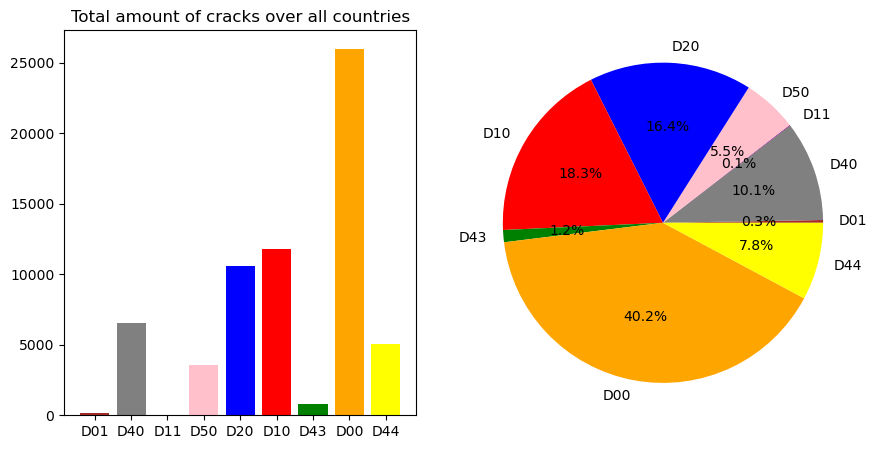

In [17]:
# set colors for categories of damages
colors = {'D01': 'brown', 'D43': 'green', 'D11': 'purple', 'D50': 'pink', 'D10': 'red', 
          'D00': 'orange', 'D44': 'yellow', 'D20': 'blue', 'D40': 'grey'}

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.bar(total_cracks.keys(), height=total_cracks.values(), color=[colors[v] for v in total_cracks.keys()])
plt.title(label='Total amount of cracks over all countries')

plt.subplot(122)
plt.pie(total_cracks.values(), labels=total_cracks.keys(), colors=[colors[v] for v in total_cracks.keys()], autopct='%0.1f%%')
plt.axis('equal')
plt.show()

Observation: What stands out is that D00 (longitudinal crack) is by far the most occurring road damage over all countries. D00 is followed by D10 (lateral crack), D20 (alligator crack) and D40 (rutting, bump, pothole, separation). The rest of the damages don't occur that often, which will probably lead to less performance on the actual object identification. 

### Differences in crack occurrences betweeen countries

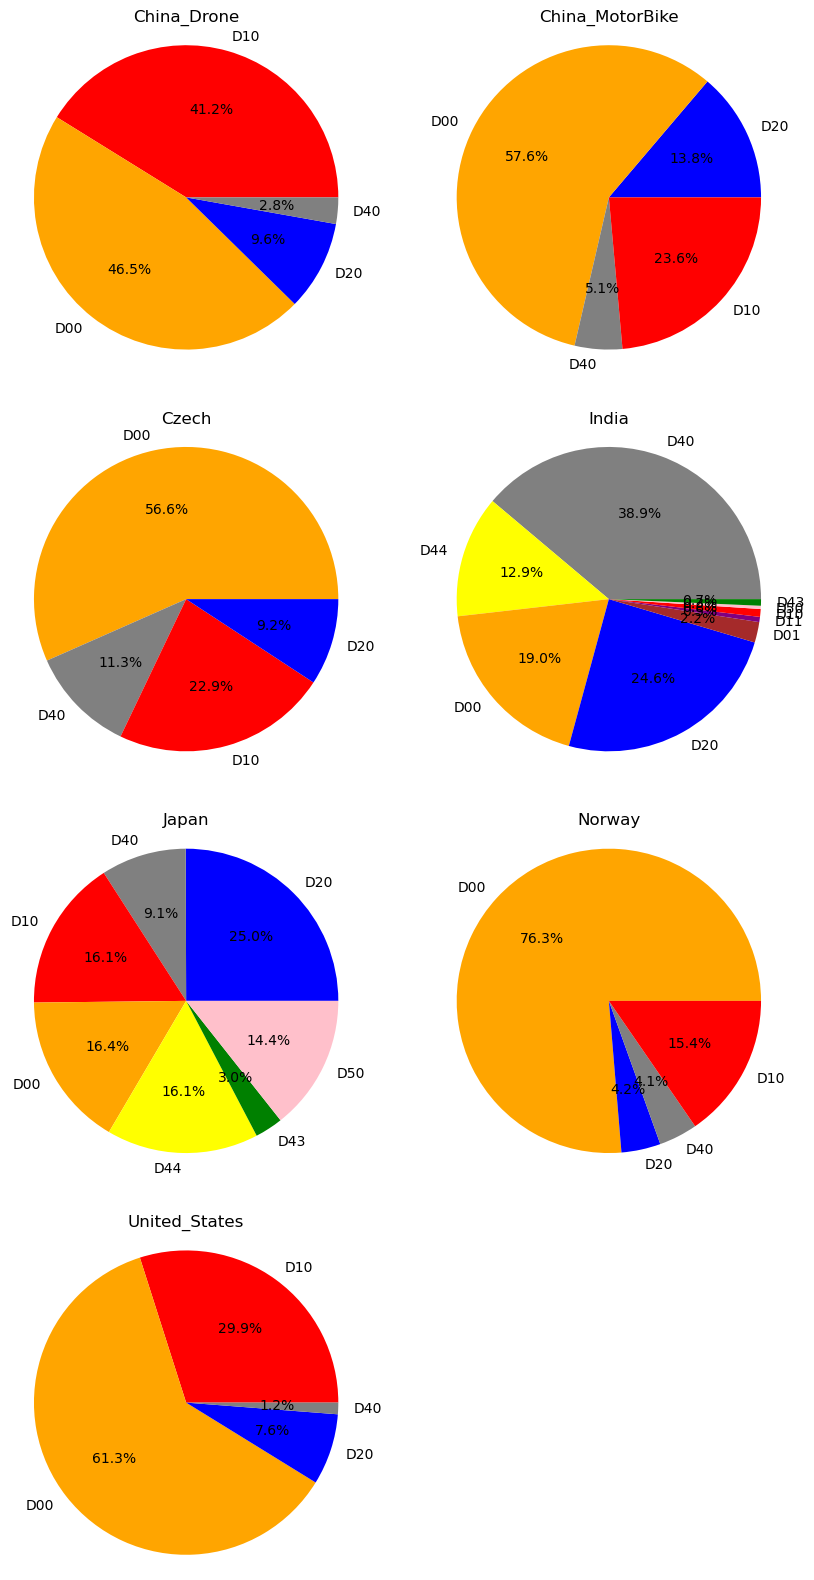

In [18]:
plt.figure(figsize=(10,20))

for i, (country, cracks) in enumerate(cracks_per_country.items()):
    # filter out non-interesting cracks
    plt.subplot(4, 2, i+1)
    cracks = {crack: num for crack, num in cracks.items() if crack in total_cracks.keys()}
    plt.pie(cracks.values(), labels=cracks.keys(), colors=[colors[v] for v in cracks.keys()], autopct='%0.1f%%')
    plt.title(country)
    plt.axis('equal')

plt.show()

Observation: What really stands out are the differences in occurrence between countries. For example, D00 is the most common damage in most of the countries, but not in Japan and India. In India, D40 (rutting, bump, pothole, separation) is by far the most occurring damage. And in Japan, D20 (alligator crack) is most occurring. Also note that in China_Drone, China_MotorBike, Czech Republic, Norway and the United States, only the four most common damages (D00, D10, D20 and D40) occur. The rest of the damages only occur in Japan and India. This could also just be the reason why the other damages don't occur that often. 

### Examples of image and found cracks in the dataset

In [19]:
# find for all countries an example image and the cracks
example_cracks_per_country = dict()

with ZipFile('RDD2022.zip', 'r') as zip: 
    # get all the contents of the zip file 
    files = zip.namelist()
    
    # go over all country folders
    for file in files:     
        country = zip.extract(file)
        with ZipFile(country, 'r') as zip2: 

            # go over all files of that country
            country = str(file).strip('RDD2022_all_countries/').strip('.zip')
            example = []
            for file in zip2.namelist():
                # for every country we obtain image 103, just because this one exists in all country's folders
                if '/train/images/' + country + '_000103.jpg' in file:
                    image = zip2.read(file)
                    example.append(image)
                
                # and also the details of the cracks in xml format
                if '/train/annotations/xmls/' + country + '_000103.xml' in file:
                    xmlstr = zip2.read(file)
                    example.append(xmlstr)
            
            # add for every country the image and details about the cracks in it
            example_cracks_per_country[country] = example

# example_cracks_per_country

In [20]:
# for every example, exctract the details about the cracks from the xml file
total = dict()

# go over all countries
for country, files in example_cracks_per_country.items():
    root = ET.fromstring(files[0])
    
    # find size of images
    width = root.find('size/width').text
    height = root.find('size/height').text
    
    # find coordinates of damages
    damages = []
    for damage in root.findall('object'):
        name = damage.find('name').text
        xmin = damage.find('bndbox/xmin').text
        xmax = damage.find('bndbox/xmax').text
        ymin = damage.find('bndbox/ymin').text
        ymax = damage.find('bndbox/ymax').text

        damages.append({'name': name, 'xmin': xmin, 'xmax': xmax, 'ymin': ymin, 'ymax': ymax})
    
    # add per country a dict with image sizes and coordinates of damages
    total[country] = {'width': width, 'height': height, 'damages': damages, 'image': files[1]}
    
# total['China_Drone']

### Show all example images and the labelled cracks within it

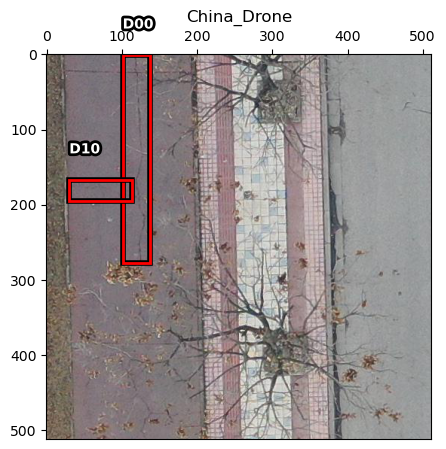

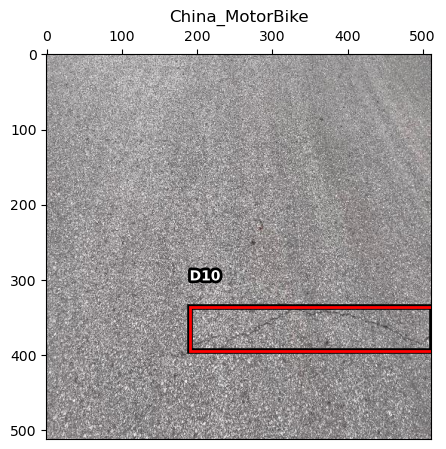

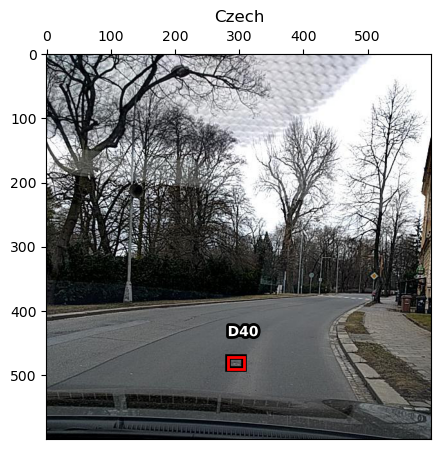

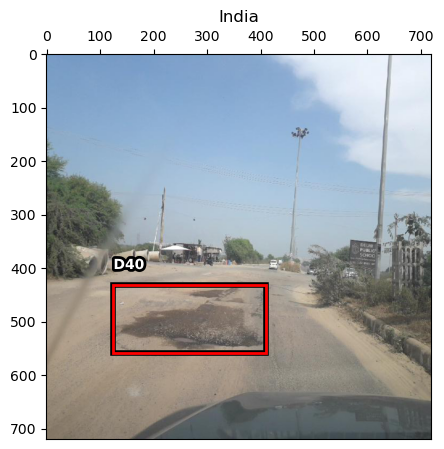

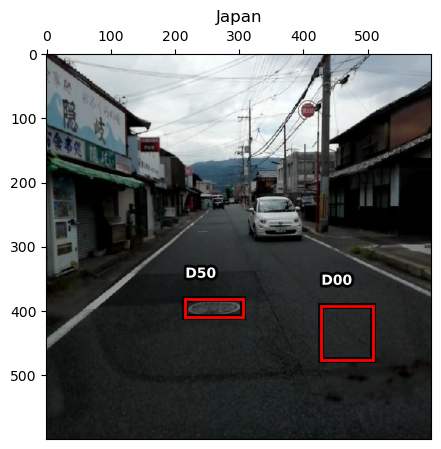

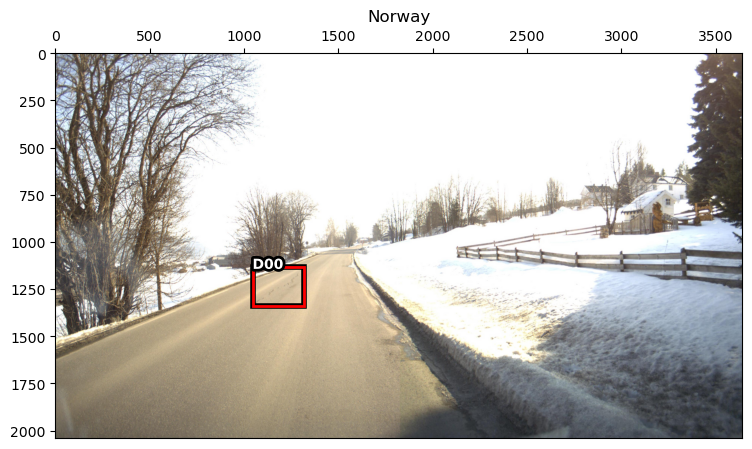

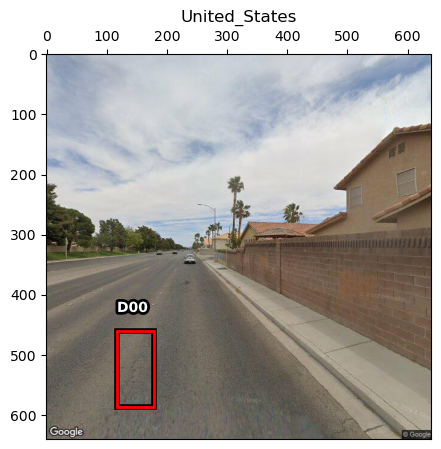

In [21]:
# go over coutries
for country, data in total.items(): 
    
    # get image
    fp = io.BytesIO(data['image'])
    with fp:
        img = mpimg.imread(fp, format='jpeg')
    
    # create figure
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.xaxis.tick_top()
    plt.title(country)
    
    # draw all damages
    for damage in data['damages']:
        x = float(damage['xmin'])
        y = float(damage['ymin'])
        w = float(damage['xmax']) - float(damage['xmin'])
        h = float(damage['ymax']) - float(damage['ymin'])
        
        ax.imshow(img)
        ax.add_patch(patches.Rectangle((x,y),w,h, fill=False, edgecolor='red', lw=2)).set_path_effects(
            [patheffects.Stroke(linewidth=4, foreground='black'), patheffects.Normal()])
        ax.text(x,(y-50),str(damage['name']),verticalalignment='top',
        color='white',fontsize=10,weight='bold').set_path_effects(
            [patheffects.Stroke(linewidth=4, foreground='black'), patheffects.Normal()])

Observation: A few things stand out. First of all, we can really see the difference here between China_Drone (images captured from the sky by a drone) and China_MotorBike. The Drone image is the only one not taken from a driving vehicle, while the others are. What also stands out is the size of the images. We can see that the image captured in Norway is of far better quality compared to the others. Let's dive into that a bit deeper. 

### Image sizes

In [22]:
# go over coutries and print the size per image
# print()
for country, data in total.items(): 
    print('Images in', country, 'are of size: \t', data['width'], 'x', data['height'])

Images in China_Drone are of size: 	 512 x 512
Images in China_MotorBike are of size: 	 512 x 512
Images in Czech are of size: 	 600 x 600
Images in India are of size: 	 720 x 720
Images in Japan are of size: 	 600 x 600
Images in Norway are of size: 	 3643 x 2041
Images in United_States are of size: 	 640 x 640


Observation: What can be seen is that images from most countries are between 500 and 750 pixels in width and height. Also images from all these countries are square. The only country from which the image sizes are really different, is Norway. Here the images are of roughly 3650 pixels by 2050 pixels. The consequence of this will be that training a model on the images of Norway will probably require way more computing power. This is also something important to consider. 

# Other datasets!

### Investment in road infrastructure

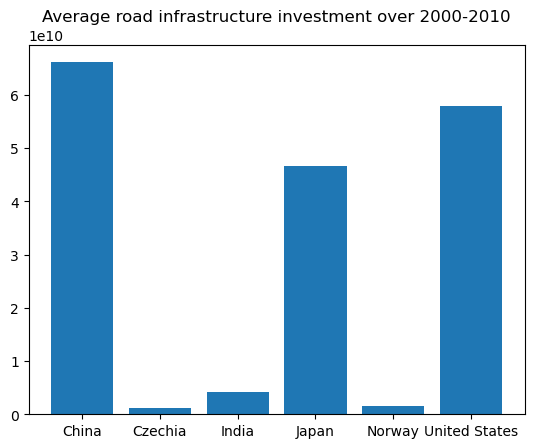

In [23]:
# specify countries
countries = ['China', 'Czechia', 'India', 'Japan', 'Norway', 'United States']

# import csv file
# source: https://stats.oecd.org/Index.aspx?DataSetCode=ITF_INV-MTN_DATA
spending = pd.read_csv('transport_infrastructure_investment_and_maintenance_spending.csv')

# filter on country and use euro as currency (for fair comparison)
per_country_eur = spending[(spending['Country'].isin(countries)) & (spending['Measure'] == 'Euro')]

# only focus on road infrastructure investment (since only this variable is measured for all countries)
spendings_road = per_country_eur[per_country_eur['Variable'] == 'Road infrastructure investment']

# only consider the years 2000 until 2010
spendings_2000_2010 = spendings_road[(spendings_road['Year'] > 1999) & (spendings_road['Year'] < 2011)]

# calculate the mean investment per country
spendings_per_country = spendings_2000_2010.groupby('Country')['Value'].mean()

plt.bar(spendings_per_country.index, height=spendings_per_country)
plt.title(label='Average road infrastructure investment over 2000-2010')
plt.show()

### Correcting for purchasing power

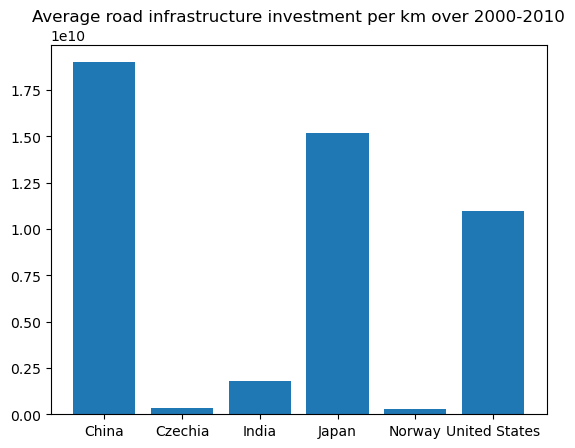

In [24]:
# pp = pd.Series({
#     'China': 14340, 
#     'Czechia': 32076,
#     'India': 6187, 
#     'Japan': 38142,
#     'Norway': 68591,
#     'United States': 56084
# })

# big mac index is used
price_bm = pd.Series({
    'China': 3.48, 
    'Czechia': 3.74,
    'India': 2.32, 
    'Japan': 3.07,
    'Norway': 5.81,
    'United States': 5.28
})

spendings_per_country = spendings_per_country / price_bm

plt.bar(spendings_per_country.index, height=spendings_per_country)
plt.title(label='Average road infrastructure investment per km over 2000-2010')
plt.show()

Observation: What can be seen here is that there's actually a lot of difference in how much countries spend on their road infrastructure. But of course, this is also due to the size of the road network. Let's see if I can correct for this factor. 

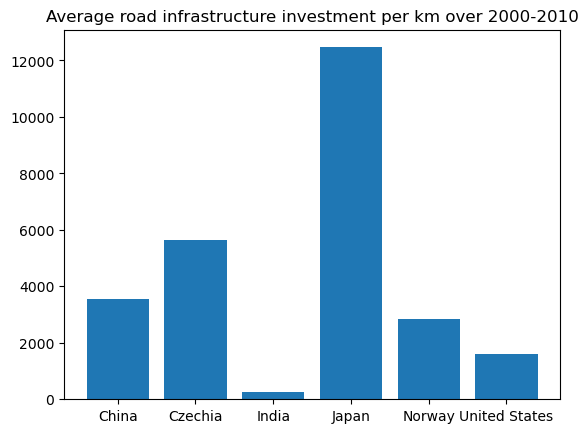

In [25]:
# correcting for km of road in each country
# source: https://en.wikipedia.org/wiki/List_of_countries_by_road_network_size
km_of_roads = pd.Series({
    'China': 5350000, 
    'Czechia': 55744,
    'India': 6700000, 
    'Japan': 1218772,
    'Norway': 94902,
    'United States': 6832000
})

spendings_per_km = spendings_per_country / km_of_roads

plt.bar(spendings_per_country.index, height=spendings_per_km)
plt.title(label='Average road infrastructure investment per km over 2000-2010')
plt.show()

Observation: Now the data already looks way better. The average investment in India does look a bit low, but not necessarily incorrect. I'm really curious to see if this data will correlate with the distribution of the road damages, or maybe with the performance of the road damage detection models. However, to find this out, first the road damage detection models will have to be trained. 

### Typical weather conditions

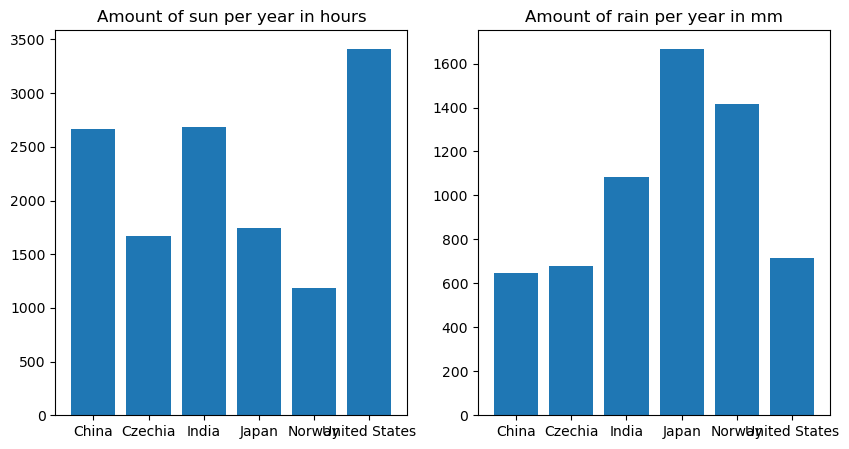

In [26]:
# hours of sun per year
# source: https://en.wikipedia.org/wiki/List_of_cities_by_sunshine_duration
sun_hours_per_year = pd.Series({
    'China': 2670, 
    'Czechia': 1668,
    'India': 2685,
    'Japan': 1740, 
    'Norway': 1187, 
    'United States': 3415
})

# millimeter rain per year
# source: https://en.wikipedia.org/wiki/List_of_countries_by_average_annual_precipitation
mm_rain_per_year = pd.Series({
    'China': 645,
    'Czechia': 677, 
    'India': 1083,
    'Japan': 1668, 
    'Norway': 1414, 
    'United States': 715, 
})

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.bar(sun_hours_per_year.index, height=sun_hours_per_year)
plt.title(label='Amount of sun per year in hours')

plt.subplot(122)
plt.bar(mm_rain_per_year.index, height=mm_rain_per_year)
plt.title(label='Amount of rain per year in mm')
plt.show()

Observation: Again, I'm really curious to see if these data will correlate with the distribution of the road damages for each country, or maybe with the performance of the road damage detection models. Again, I'll have to wait for the results of the road damage detection models performance measurements to find this out. 

### Quick check for correlations between relative frequencies of cracks per country and new datasets

In [27]:
# create dataframe with percentages of total frequency per country
df = pd.DataFrame(cracks_per_country).fillna(0).drop(['Repair', 'Block crack', 'D0w0', 'D50'])
df['China'] = df['China_Drone'] + df['China_MotorBike']
df = df.drop(['China_Drone', 'China_MotorBike'], axis=1).T
df['sum'] = df.sum(axis=1)
df = df.loc[:].div(df["sum"], axis=0).drop(['sum'], axis=1)
df = df.rename(index={"Czech": "Czechia", "United_States": "United States"})

df

,D10,D00,D20,D40,D44,D01,D11,D43
Czechia,0.228653,0.566189,0.092264,0.112894,0.000000,0.000000,0.000000,0.000000
India,0.008319,0.190237,0.247247,0.389895,0.129924,0.021899,0.005505,0.006973
Japan,0.187680,0.190982,0.292392,0.105797,0.188435,0.000000,0.000000,0.034715
Norway,0.154065,0.763202,0.041678,0.041054,0.000000,0.000000,0.000000,0.000000
United States,0.299165,0.612856,0.075722,0.012257,0.000000,0.000000,0.000000,0.000000
China,0.305649,0.531744,0.121016,0.041591,0.000000,0.000000,0.000000,0.000000


In [28]:
# add the new data
df['spendings_per_km'] = spendings_per_km
df['sun_hours_per_year'] = sun_hours_per_year
df['mm_rain_per_year'] = mm_rain_per_year


# China_Drone = {'metrics/precision(B)': 0.5089556863345432, 'metrics/recall(B)': 0.41118501198108004, 'metrics/mAP50(B)': 0.43981058695716535, 'metrics/mAP50-95(B)': 0.2525529384579092, 'fitness': 0.2712787033078348}
# China_MotorBike = {'metrics/precision(B)': 0.842532151864547, 'metrics/recall(B)': 0.7638964763690084, 'metrics/mAP50(B)': 0.8462683507216078, 'metrics/mAP50-95(B)': 0.5487144681853965, 'fitness': 0.5784698564390176}
# Czech = {'metrics/precision(B)': 0.20827427288723038, 'metrics/recall(B)': 0.16609777419767663, 'metrics/mAP50(B)': 0.11522658493963553, 'metrics/mAP50-95(B)': 0.039513608249910744, 'fitness': 0.04708490591888322}
# India = {'metrics/precision(B)': 0.5765913623454217, 'metrics/recall(B)': 0.2505979340720683, 'metrics/mAP50(B)': 0.2341042335562332, 'metrics/mAP50-95(B)': 0.10913611400519954, 'fitness': 0.12163292596030291}
# Japan = {'metrics/precision(B)': 0.637073156335231, 'metrics/recall(B)': 0.5954761969268724, 'metrics/mAP50(B)': 0.6379186595386079, 'metrics/mAP50-95(B)': 0.3604147239777293, 'fitness': 0.3881651175338171}
# Norway = {'metrics/precision(B)': 0.38215400018946993, 'metrics/recall(B)': 0.10046107617906674, 'metrics/mAP50(B)': 0.06405661206219282, 'metrics/mAP50-95(B)': 0.024065710698404998, 'fitness': 0.02806480083478378}
# United_States = {'metrics/precision(B)': 0.700631874948364, 'metrics/recall(B)': 0.45164390814106437, 'metrics/mAP50(B)': 0.47233331755989716, 'metrics/mAP50-95(B)': 0.26014449316992344, 'fitness': 0.28136337560892083}


# China_Drone = {'metrics/precision(B)': 0.33701674245839275, 'metrics/recall(B)': 0.3202133907186783, 'metrics/mAP50(B)': 0.2726976926424472, 'metrics/mAP50-95(B)': 0.1375324531564496, 'fitness': 0.1510489771050494}
# China_MotorBike = {'metrics/precision(B)': 0.0054270153583977805, 'metrics/recall(B)': 0.25721666128758786, 'metrics/mAP50(B)': 0.0038725612184810966, 'metrics/mAP50-95(B)': 0.0017744699248763676, 'fitness': 0.0019842790542368405}
# Czech = {'metrics/precision(B)': 0.002516621360078063, 'metrics/recall(B)': 0.20859823563203206, 'metrics/mAP50(B)': 0.0017010093954116564, 'metrics/mAP50-95(B)': 0.0006481918898310656, 'fitness': 0.0007534736403891247}
# India = {'metrics/precision(B)': 0.004397403192130311, 'metrics/recall(B)': 0.012771096862283874, 'metrics/mAP50(B)': 0.0023777795659628027, 'metrics/mAP50-95(B)': 0.0010549162738585887, 'fitness': 0.0011872026030690101}
# Japan = {'metrics/precision(B)': 0.002856851955578817, 'metrics/recall(B)': 0.10943006596197792, 'metrics/mAP50(B)': 0.0015787303515698585, 'metrics/mAP50-95(B)': 0.0007327950680525609, 'fitness': 0.0008173885964042907}
# Norway = {'metrics/precision(B)': 0.024873726814299092, 'metrics/recall(B)': 0.24196670217581395, 'metrics/mAP50(B)': 0.01369034340285927, 'metrics/mAP50-95(B)': 0.006466320965053765, 'fitness': 0.007188723208834316}
# United_States = {'metrics/precision(B)': 0.42954765731838573, 'metrics/recall(B)': 0.41119720874792326, 'metrics/mAP50(B)': 0.42196276076588435, 'metrics/mAP50-95(B)': 0.2256350016703766, 'fitness': 0.24526777757992738}

# longer training
China_Drone = {'metrics/precision(B)': 0.7171049689474248, 'metrics/recall(B)': 0.5415537527918061, 'metrics/mAP50(B)': 0.5758518148333605, 'metrics/mAP50-95(B)': 0.35993594800801226, 'fitness': 0.3815275346905471}
China_MotorBike = {'metrics/precision(B)': 0.016424034845674073, 'metrics/recall(B)': 0.31342588481303946, 'metrics/mAP50(B)': 0.013450990940616775, 'metrics/mAP50-95(B)': 0.008586447739006227, 'fitness': 0.009072902059167281}
Czech = {'metrics/precision(B)': 0.0043815497159616044, 'metrics/recall(B)': 0.2508812542876128, 'metrics/mAP50(B)': 0.003014189020369654, 'metrics/mAP50-95(B)': 0.0012469978866951137, 'fitness': 0.001423717000062568}
India = {'metrics/precision(B)': 0.0033321882143911422, 'metrics/recall(B)': 0.14544000330524115, 'metrics/mAP50(B)': 0.0026943703887394284, 'metrics/mAP50-95(B)': 0.00118094573205946, 'fitness': 0.0013322881977274569}
Japan = {'metrics/precision(B)': 0.0024484578039990386, 'metrics/recall(B)': 0.08821178754289473, 'metrics/mAP50(B)': 0.0013899769871223585, 'metrics/mAP50-95(B)': 0.0006620210040119228, 'fitness': 0.0007348166023229664}
Norway = {'metrics/precision(B)': 0.08465248887191998, 'metrics/recall(B)': 0.24918935939706116, 'metrics/mAP50(B)': 0.043758861305011304, 'metrics/mAP50-95(B)': 0.029705099053835123, 'fitness': 0.03111047527895274}
United_States = {'metrics/precision(B)': 0.751385381186106, 'metrics/recall(B)': 0.5020584802769823, 'metrics/mAP50(B)': 0.5391522089871014, 'metrics/mAP50-95(B)': 0.32577928512561277, 'fitness': 0.34711657751176167}



df2 = pd.DataFrame({'China_Drone': China_Drone, 'China': China_MotorBike, 'Czechia': Czech, 'India': India, 'Japan': Japan, 'Norway': Norway, 'United States': United_States}).T


df2 = df.join(df2)
df3 = df2[['D00', 'D01', 'D10', 'D11', 'D20', 'D40', 'D43', 'D44', 'spendings_per_km', 'sun_hours_per_year', 'mm_rain_per_year']]
df4 = df2[['spendings_per_km', 'sun_hours_per_year', 'mm_rain_per_year', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'fitness']]
display(df3)
display(df4)

,D00,D01,D10,D11,D20,D40,D43,D44,spendings_per_km,sun_hours_per_year,mm_rain_per_year
Czechia,0.566189,0.000000,0.228653,0.000000,0.092264,0.112894,0.000000,0.000000,5639.417044,1668,677
India,0.190237,0.021899,0.008319,0.005505,0.247247,0.389895,0.006973,0.129924,270.549965,2685,1083
Japan,0.190982,0.000000,0.187680,0.000000,0.292392,0.105797,0.034715,0.188435,12464.143138,1740,1668
Norway,0.763202,0.000000,0.154065,0.000000,0.041678,0.041054,0.000000,0.000000,2847.942618,1187,1414
United States,0.612856,0.000000,0.299165,0.000000,0.075722,0.012257,0.000000,0.000000,1605.368270,3415,715
China,0.531744,0.000000,0.305649,0.000000,0.121016,0.041591,0.000000,0.000000,3550.148750,2670,645


,spendings_per_km,sun_hours_per_year,mm_rain_per_year,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),fitness
Czechia,5639.417044,1668,677,0.004382,0.250881,0.003014,0.001247,0.001424
India,270.549965,2685,1083,0.003332,0.145440,0.002694,0.001181,0.001332
Japan,12464.143138,1740,1668,0.002448,0.088212,0.001390,0.000662,0.000735
Norway,2847.942618,1187,1414,0.084652,0.249189,0.043759,0.029705,0.031110
United States,1605.368270,3415,715,0.751385,0.502058,0.539152,0.325779,0.347117
China,3550.148750,2670,645,0.016424,0.313426,0.013451,0.008586,0.009073


In [30]:
!pip install dataframe_image
import dataframe_image as dfi

dfi.export(df3.corr(), 'crack_occurance.png')

df3.corr()

,D00,D01,D10,D11,D20,D40,D43,D44,spendings_per_km,sun_hours_per_year,mm_rain_per_year
D00,1.000000,-0.596282,0.518986,-0.596282,-0.982802,-0.706649,-0.729238,-0.918373,-0.368865,-0.157934,-0.361980
D01,-0.596282,1.000000,-0.839547,1.000000,0.495666,0.958778,0.000890,0.446917,-0.464768,0.269873,0.056060
D10,0.518986,-0.839547,1.000000,-0.839547,-0.495391,-0.874397,-0.215545,-0.567361,0.180212,0.250287,-0.494950
D11,-0.596282,1.000000,-0.839547,1.000000,0.495666,0.958778,0.000890,0.446917,-0.464768,0.269873,0.056060
D20,-0.982802,0.495666,-0.495391,0.495666,1.000000,0.616576,0.830981,0.964503,0.489632,0.045435,0.502707
D40,-0.706649,0.958778,-0.874397,0.958778,0.616576,1.000000,0.155464,0.566805,-0.246817,0.093138,0.138608
D43,-0.729238,0.000890,-0.215545,0.000890,0.830981,0.155464,1.000000,0.894973,0.832316,-0.238172,0.747187
D44,-0.918373,0.446917,-0.567361,0.446917,0.964503,0.566805,0.894973,1.000000,0.537227,-0.092667,0.693425
spendings_per_km,-0.368865,-0.464768,0.180212,-0.464768,0.489632,-0.246817,0.832316,0.537227,1.000000,-0.475889,0.544069
sun_hours_per_year,-0.157934,0.269873,0.250287,0.269873,0.045435,0.093138,-0.238172,-0.092667,-0.475889,1.000000,-0.577177


In [31]:
dfi.export(df4.corr(), 'performances.png')
df4.corr()

,spendings_per_km,sun_hours_per_year,mm_rain_per_year,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),fitness
spendings_per_km,1.000000,-0.475889,0.544069,-0.342692,-0.518705,-0.337258,-0.339529,-0.339179
sun_hours_per_year,-0.475889,1.000000,-0.577177,0.651108,0.598318,0.670114,0.665055,0.665847
mm_rain_per_year,0.544069,-0.577177,1.000000,-0.330838,-0.685520,-0.345491,-0.341696,-0.342288
metrics/precision(B),-0.342692,0.651108,-0.330838,1.000000,0.844628,0.999462,0.999742,0.999707
metrics/recall(B),-0.518705,0.598318,-0.685520,0.844628,1.000000,0.843791,0.845249,0.845029
metrics/mAP50(B),-0.337258,0.670114,-0.345491,0.999462,0.843791,1.000000,0.999939,0.999957
metrics/mAP50-95(B),-0.339529,0.665055,-0.341696,0.999742,0.845249,0.999939,1.000000,0.999999
fitness,-0.339179,0.665847,-0.342288,0.999707,0.845029,0.999957,0.999999,1.000000


Observation: There are some quite interesting findings already. For example, in terms of spendings per km of road, it looks like the more they spend, the less of cracks like D01 and D11 relatively. But on the other side, relatively more D43 cracks occur. In terms of sun hours, there is not much correlation found. But in terms of mm rain per year, again some interesting findings are the result. The more rain, the less D10 and D00 cracks. And on the other hand, the more rain, the more D20, D44 and D43 cracks occur. However, what must be considered is that not all the cracks are equally present within the dataset of each country, especially D44, D01, D11 and D43. This could have influenced these results, and has to be investigated further. But the findings about D10, D00, D20 and D40 are definetely really interesting, and therefore should also be investigated further. From these results you could already see that with a lot of rain, D20 (alligator cracks) are way more likely to occur than D00 and D10 (longitudinal and lateral crack). 

In [ ]:
# Interesting findings

# moderate correlation between rain per year and occurance of D20 - alligator cracks (0.50) -> suggesting that in countries where it rains more than average, relatively more alligator cracks will occur in the road surface
# weak/moderate negative correlation between rain per year and occurance of D00 - longitudinal cracks (-0.36) -> suggesting that more rain results in relatively less longitudinal cracks in the roads
# moderate negative correlation between rain per year and occurance of D10 - lateral cracks (-0.49) -> suggesting that more rain results in relatively less lateral cracks in the roads

# moderate correlation between spendings per km and rain per year (0.54) -> suggesting that in countries where it rains more, more money is spent on road maintenance

# weak/moderate negative correlation between rain per year and mAP50-95(-0.34) -> suggesting that in countries where it rains more, models are likely to perform worse
# strong correlation between sun hours per year and mAP50-95(B) (0.67) -> suggesting that in countries where the sun is shining more, road damage detection models are likely to perform better
